<a href="https://colab.research.google.com/github/sawadi807/MyML/blob/%EC%84%9C%EC%9A%B8%EC%8B%9C%ED%8F%89%EA%B7%A0%EA%B8%B0%EC%98%A8/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 설정

In [ ]:
import sys
import random
import os
import zipfile
import matplotlib
import datetime
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path

# 한글 폰트
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

matplotlib.rcParams['figure.figsize'] = (16, 8)
matplotlib.rcParams['axes.grid'] = False

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed=3407
seed_everything(seed)

In [ ]:
ROOT_PATH = Path("/content/drive/MyDrive/데이콘/서울시평균기온")
DATA_PATH = ROOT_PATH / "data"
os.makedirs(DATA_PATH, exist_ok=True)

SAVE_PATH = DATA_PATH / "submit"
os.makedirs(SAVE_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH / "train.csv"):
  with zipfile.ZipFile(ROOT_PATH / "open.zip", 'r') as f:
    f.extractall(DATA_PATH)

# 데이터

In [ ]:
raw_train = pd.read_csv(DATA_PATH / 'train.csv')
raw_train

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6
...,...,...,...,...,...,...,...,...,...,...,...
23006,2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6
23007,2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3
23008,2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9
23009,2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8


In [ ]:
df = raw_train.loc[raw_train['일시'] >= '1980-01-01']
df.reset_index(drop=True, inplace=True)

In [ ]:
date_time = pd.to_datetime(df.pop('일시'), format='%Y-%m-%d')

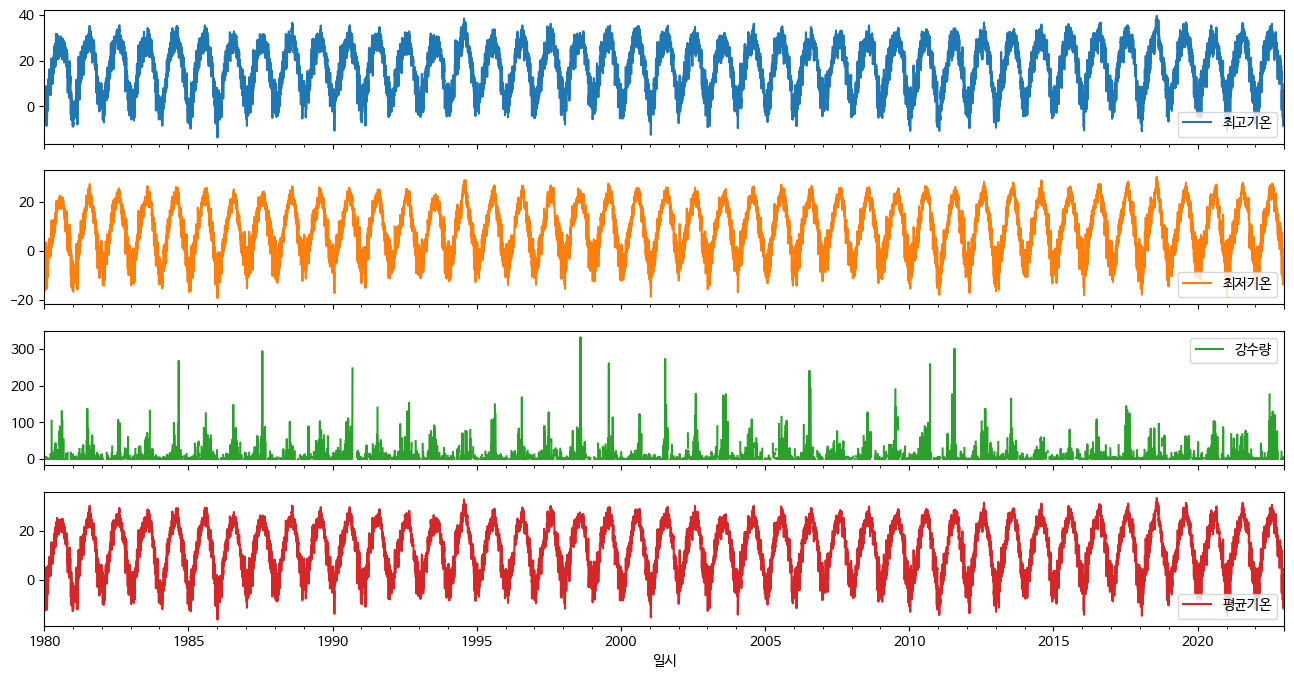

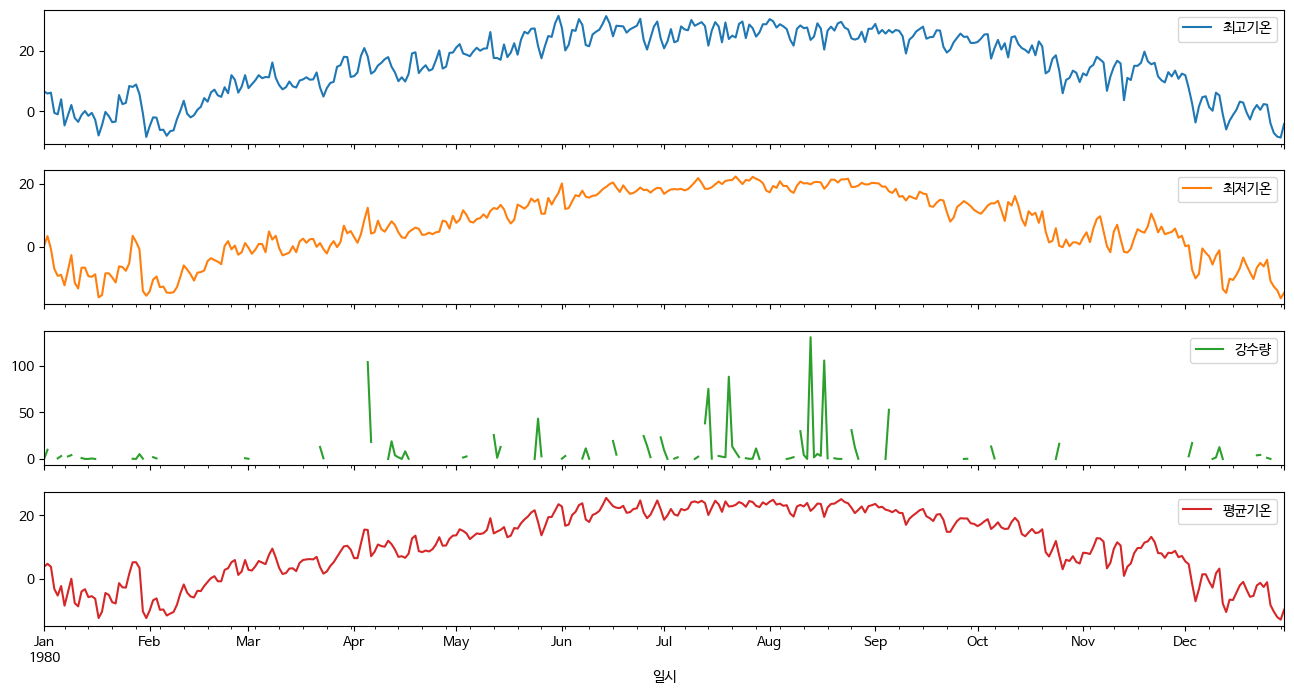

In [ ]:
plot_cols = ['최고기온', '최저기온', '강수량', '평균기온']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:365]
plot_features.index = date_time[:365]
_ = plot_features.plot(subplots=True)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
최고기온,15705.0,17.277122,10.638255,-13.6,8.10,19.10,26.50,39.60
최저기온,15705.0,8.743260,10.510999,-19.2,0.00,9.50,18.20,30.30
일교차,15704.0,8.533157,2.871063,1.0,6.60,8.50,10.50,19.10
강수량,6106.0,9.901802,22.922379,0.0,0.10,1.50,8.90,332.80
평균습도,15706.0,63.325551,14.697941,17.9,52.60,63.50,74.00,99.80
평균풍속,15702.0,2.359890,0.905467,0.1,1.70,2.20,2.80,7.80
일조합,15692.0,5.914772,3.832599,0.0,2.30,6.70,9.00,13.70
일사합,15668.0,11.987993,6.552455,0.0,6.93,11.26,16.75,33.48
일조율,15706.0,49.316962,31.740460,0.0,18.90,56.30,78.60,96.90
평균기온,15706.0,12.685623,10.425703,-16.4,3.80,14.10,22.00,33.70


In [ ]:
len(df)

15706

## 결측치

최고기온, 최저기온, 일교차, 강수량, 평균풍속, 일조합, 일사합에 결측치를 처리할 필요가 있다
- 최고기온, 최저기온, 평균풍속, 일조합, 일사합 결측치는 선형보간으로 대체
- 보간된 최고기온과 최저기온을 통해 일교차 결측치를 계산

In [ ]:
null_cols = ['최고기온', '최저기온', '평균풍속', '일조합', '일사합']
for col in null_cols:
  df[col].interpolate(method='linear', inplace=True)

df['일교차'] = df['최고기온'] - df['최저기온']

- 강수량 결측치는 0으로 대체

In [ ]:
df.loc[df['강수량'].isnull(), '강수량'] = 0.0

In [ ]:
df.isnull().sum()

최고기온    0
최저기온    0
일교차     0
강수량     0
평균습도    0
평균풍속    0
일조합     0
일사합     0
일조율     0
평균기온    0
dtype: int64

그런데 (일교차 = 최고기온 - 최저기온) 이라는 수식이 성립하므로 다중공선성에 의해 일교차 feature는 drop하는 것이 좋아 보임

In [ ]:
df.drop('일교차', axis=1, inplace=True)

## 시간

In [ ]:
# 날짜 데이터
date_data = pd.date_range(start='1980-01-01', end='2022-12-31', freq='D')

# 일 단위 추출
day_of_year = date_data.dayofyear

# 주기 함수로 변환
df['Day sin'] = np.sin(2 * np.pi * day_of_year / 365)
df['Day cos'] = np.cos(2 * np.pi * day_of_year / 365)

Text(0.5, 1.0, 'Time of day signal')

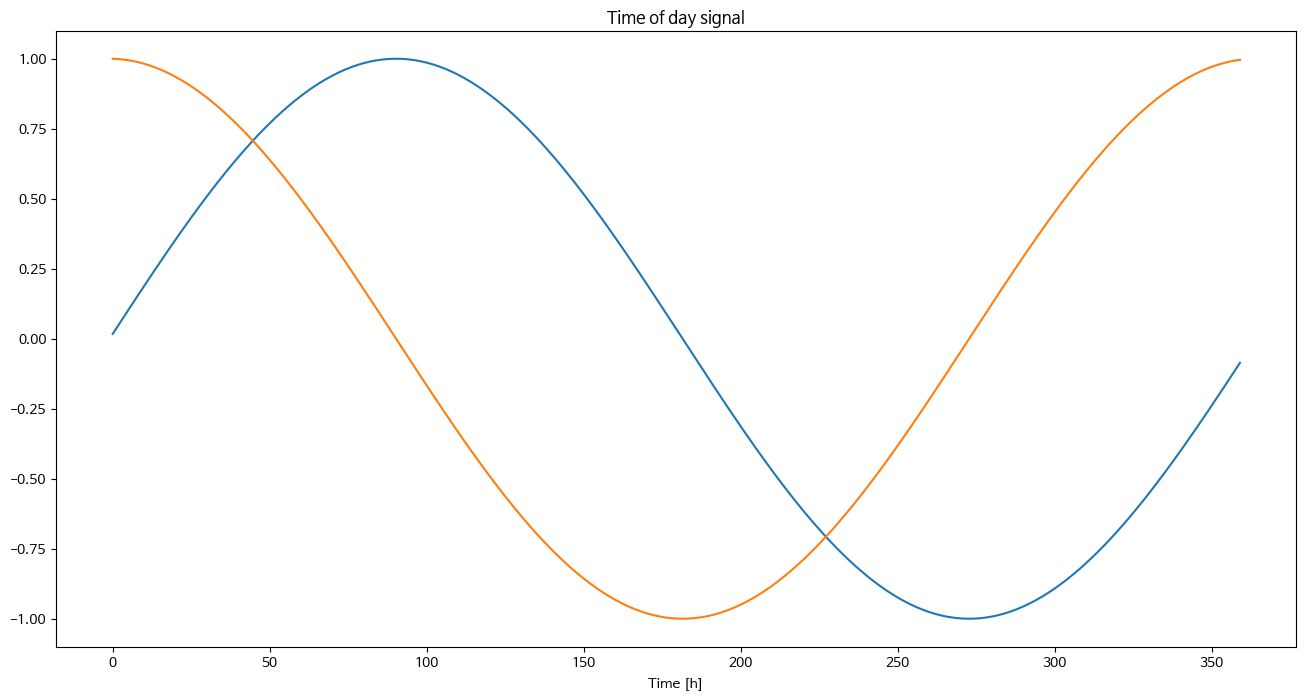

In [ ]:
plt.plot(np.array(df['Day sin'])[:360])
plt.plot(np.array(df['Day cos'])[:360])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## 데이터 분할

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]

num_features = df.shape[1]

## 정규화

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

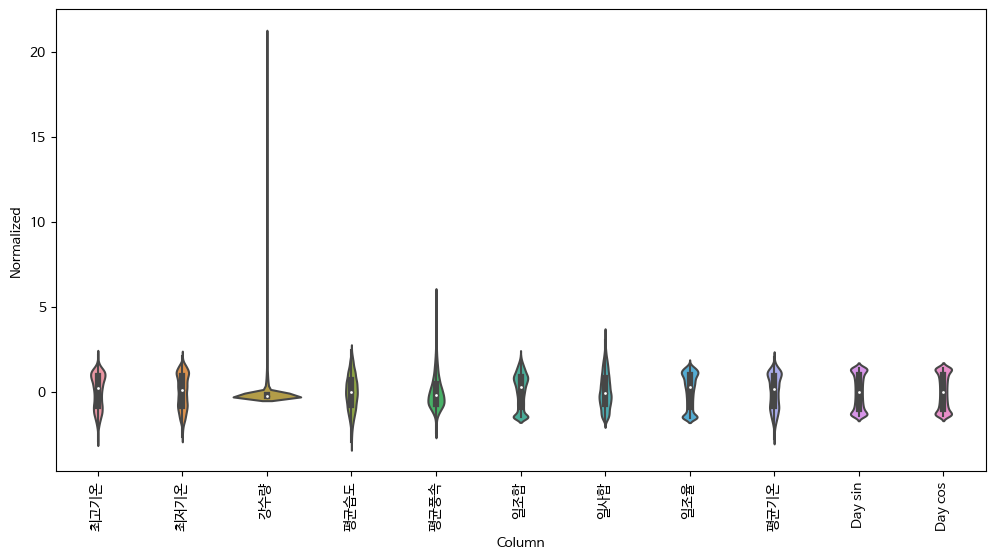

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

강수량 데이터의 이상치 처리 여부에 따른 학습 결과 확인 필요

# WindowGenerator

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='평균기온', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.example = example

# 훈련

In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
OUT_STEPS = 358
INPUT_WIDTH = OUT_STEPS * 3
multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['평균기온'])

multi_window.train.element_spec

(TensorSpec(shape=(None, 1074, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 358, 1), dtype=tf.float32, name=None))

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

multi_model_with_cnn = Sequential([
    # LSTM layers
    LSTM(128, return_sequences=True),

    # Convolutional layers with pooling
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Max pooling layer

    LSTM(256, return_sequences=True),

    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Max pooling layer

    LSTM(512, return_sequences=True),

    Conv1D(512, kernel_size=3, activation='relu', padding='same'),
    Conv1D(512, kernel_size=3, activation='relu', padding='same'),
    Conv1D(512, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Max pooling layer

    LSTM(1024, return_sequences=True),

    Conv1D(1024, kernel_size=3, activation='relu', padding='same'),
    Conv1D(1024, kernel_size=3, activation='relu', padding='same'),
    Conv1D(1024, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),  # Max pooling layer

    LSTM(1024, return_sequences=True),

    # Flatten layer to connect Conv1D and Dense layers
    Flatten(),

    # Fully Connected (Dense) layers
    Dense(512, activation='relu'),
    Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])


history = compile_and_fit(multi_model_with_cnn, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM_CNN_Pooling'] = multi_model_with_cnn.evaluate(multi_window.val)
multi_performance['LSTM_CNN_Pooling'] = multi_model_with_cnn.evaluate(multi_window.val, verbose=0)


Epoch 1/100
348/348 [==============================] - 129s 311ms/step - loss: 0.4706 - mean_absolute_error: 0.5078 - val_loss: 0.3030 - val_mean_absolute_error: 0.4319
Epoch 2/100
348/348 [==============================] - 109s 313ms/step - loss: 0.1712 - mean_absolute_error: 0.3162 - val_loss: 0.1441 - val_mean_absolute_error: 0.2965
Epoch 3/100
348/348 [==============================] - 104s 299ms/step - loss: 0.9533 - mean_absolute_error: 0.8330 - val_loss: 1.0395 - val_mean_absolute_error: 0.8784
Epoch 4/100
348/348 [==============================] - 105s 303ms/step - loss: 0.9961 - mean_absolute_error: 0.8705 - val_loss: 1.0399 - val_mean_absolute_error: 0.8784
Epoch 5/100
348/348 [==============================] - 105s 303ms/step - loss: 0.9961 - mean_absolute_error: 0.8703 - val_loss: 1.0399 - val_mean_absolute_error: 0.8784
Epoch 6/100
348/348 [==============================] - 105s 302ms/step - loss: 0.9961 - mean_absolute_error: 0.8703 - val_loss: 1.0400 - val_mean_absolute_

train 데이터의 일부분을 뽑아서 plot

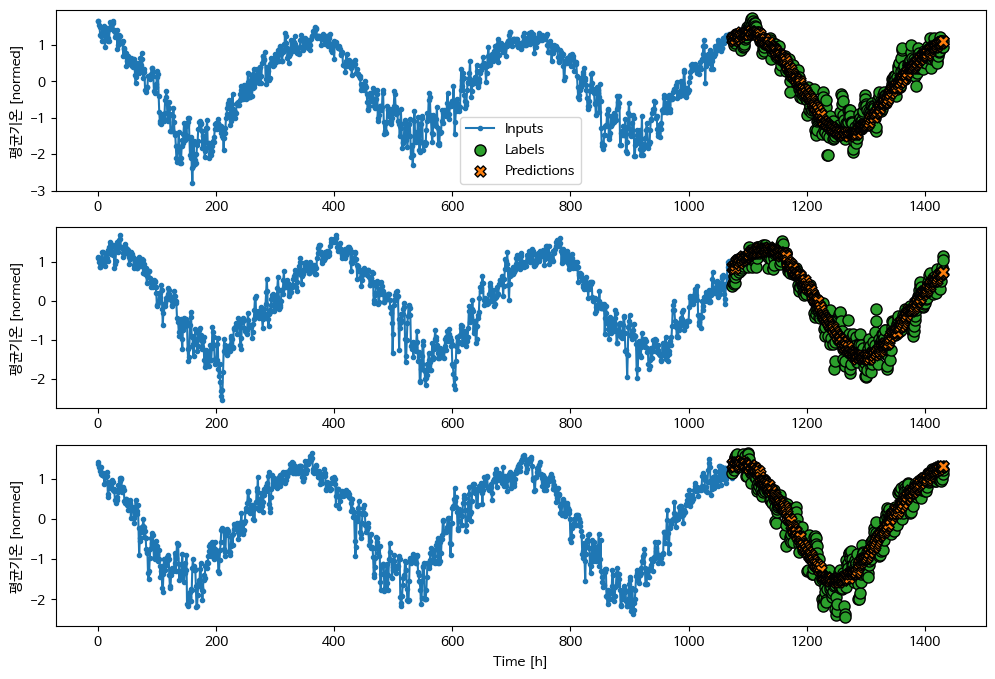

In [ ]:
multi_window.plot(multi_model_with_cnn)

# 예측

In [ ]:
input_for_submit = val_df[-INPUT_WIDTH:].values.reshape(1, INPUT_WIDTH, 11)

In [ ]:
pred = multi_model_with_cnn.predict(input_for_submit)

1/1 [==============================] - 1s 1s/step


In [ ]:
pred.shape

(1, 358, 1)

In [ ]:
prediction = pred[-1].reshape(-1,) * train_std['평균기온'] + train_mean['평균기온']

In [ ]:
sub = pd.read_csv(DATA_PATH / 'sample_submission.csv')
sub['평균기온'] = prediction

sub.to_csv(SAVE_PATH / 'Simple_LSTM.csv', index=False)